<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 Workaround 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])
df.tail()

aggiornamento al 2020-04-09


,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
41,2020-04-05T17:00:00,ITA,28949,3977,32926,58320,91246,2972,4316,21815,15887,128948,691461,NaN,NaN
42,2020-04-06T17:00:00,ITA,28976,3898,32874,60313,93187,1941,3599,22837,16523,132547,721732,NaN,NaN
43,2020-04-07T17:00:00,ITA,28718,3792,32510,61557,94067,880,3039,24392,17127,135586,755445,NaN,NaN
44,2020-04-08T17:00:00,ITA,28485,3693,32178,63084,95262,1195,3836,26491,17669,139422,807125,NaN,NaN
45,2020-04-09T17:00:00,ITA,28399,3605,32004,64873,96877,1615,4204,28470,18279,143626,853369,NaN,NaN


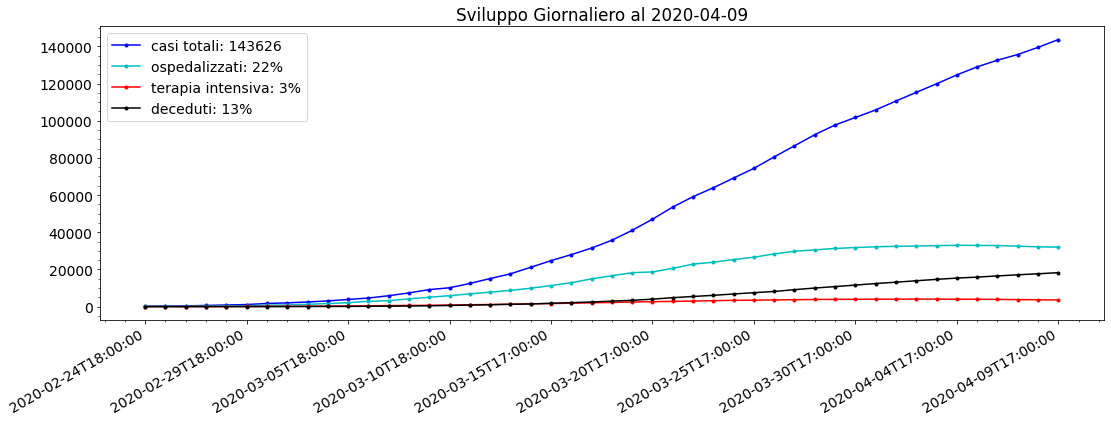

In [2]:
# visualize Daly data of infected and death people
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
fig, ax = plt.subplots(figsize=(18,6))
fig.autofmt_xdate()
ax.plot(df['data'], df['totale_casi'], 'b.-', label='casi totali: '+str(np.array(df['totale_casi'])[-1]))
perc_ospedalizzati = 100*np.array(df['totale_ospedalizzati'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['totale_ospedalizzati'], 'c.-', label='ospedalizzati: {0:.0f}%'.format(perc_ospedalizzati))
perc_intensiva = 100*np.array(df['terapia_intensiva'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['terapia_intensiva'], 'r.-', label='terapia intensiva: {0:.0f}%'.format(perc_intensiva))
perc_deceduti = 100*np.array(df['deceduti'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['deceduti'], 'k.-', label='deceduti: {0:.0f}%'.format(perc_deceduti))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Sviluppo Giornaliero al '+str(np.array(df['data'])[-1])[0:10])
#ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.legend(loc=2)
plt.minorticks_on()
plt.show()

In [0]:
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)

def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)

# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))

def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))

def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2

def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))

def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Line(x, m, q):
    import numpy as np
    return m*x + q

def fitErr3(func, x, popt, pcov):
  import numpy as np
  sigma = np.sqrt([pcov[0,0], pcov[1,1], pcov[2,2]])
  values = np.array([
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] + sigma[2]), 
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2]),   
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] - sigma[2]), 
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] - sigma[2]), 
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] + sigma[2]), 
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] + sigma[2]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2]), 
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] - sigma[2]) 
    ])
  return np.std(values, axis=0)

def fitErr2(func, x, popt, pcov):
  import numpy as np
  sigma = np.sqrt([pcov[0,0], pcov[1,1]])
  values = np.array([
    func(x, popt[0] + sigma[0], popt[1] + sigma[1]), 
    func(x, popt[0] + sigma[0], popt[1] - sigma[1]),    
    func(x, popt[0] - sigma[0], popt[1] + sigma[1]),
    func(x, popt[0] - sigma[0], popt[1] - sigma[1]) 
    ])
  return np.std(values, axis=0)

def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.sum(np.sqrt(x)) for x in a_split]
    return a_split_avg, a_split_err
  else:
    return arr, np.sqrt(arr)

def GFPlot(arr, ax, mediasu=1, fmt='k', label='', stat=False):
  y, err = ManSdtSubArr(arr, mediasu)
  x = np.linspace(0, len(arr), len(y))

  ax.errorbar(x, y, xerr=0, yerr=err, fmt=fmt+'.', label=label)


  popt, pcov = curve_fit(Gauss3,x, y, sigma=err, p0=[max(y),len(y)/2, len(y)/4])
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, Gauss3(x, *popt))

  sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
  \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
  print(sstat)


  x = np.linspace(0, 80, 100)
  y = Gauss3(x, *popt)
  yp = Gauss3(x, *popt) + 3*fitErr3(Gauss3, x, popt, pcov)
  yl = Gauss3(x, *popt) - 3*fitErr3(Gauss3, x, popt, pcov)
  if stat:
    label=sstat
  else:
    label=''
  ax.plot(x, y, fmt+'-', alpha=0.5, label=label)
  ax.fill_between(x, yl, yp, facecolor=fmt, alpha=0.2)


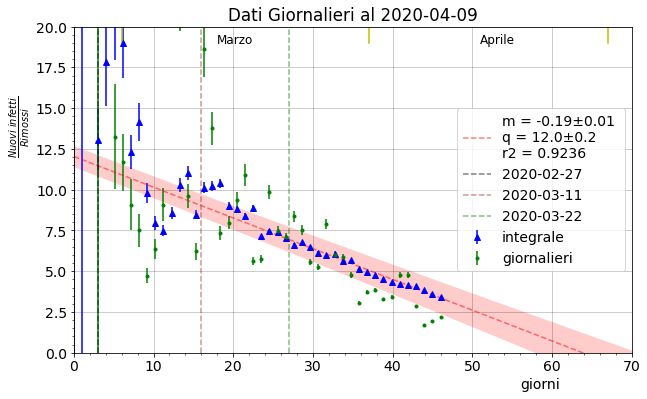

In [4]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))

a = df['totale_positivi']
b = df['dimessi_guariti']
y = a/b
err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)

ax.errorbar(x, y, yerr=err, fmt='b^', label='integrale')

day=16
mq,mqc = curve_fit(Line,x[x>day], y[x>day], p0=[-1,30], sigma=err[x>day])
mqe = np.sqrt(np.diag(mqc))
r2=r2_score(y[x>day] , Line(x[x>day], *mq))

a = df['nuovi_positivi'][x>3]
b = np.gradient(df['dimessi_guariti'][x>3],x[x>3])
y = a/b
err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)

ax.errorbar(x[x>3], y, yerr=err, fmt='g.', label='giornalieri')




x = np.linspace(0, 100, 100)
y = Line(x, *mq)
yp = y + 3*fitErr2(Line, x, mq, mqc)
yl = y - 3*fitErr2(Line, x, mq, mqc)
ax.plot(x, y, 'r--', alpha=0.5, label='m = {0:.2f}±{1:.2f} \nq = {2:.1f}±{3:.1f} \nr2 = {4:.4f}'.format(mq[0], mqe[0], mq[1], mqe[1], r2) )
ax.fill_between(x, yl, yp, facecolor='red', alpha=0.2)


day=3
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day =16
ax.axvline(day, color='brown', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day =27
ax.axvline(day, color='green', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)

ax.set_title('Dati Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$\frac{Nuovi\ infetti}{Rimossi}$', horizontalalignment = 'left', y=0.6)
# ax.text(50, 5, 'y = 0 il {:.0f}mo giorno'.format(-mq[1]/mq[0] ), fontsize=12)
# ax.axhline(1, color='red')
ax.legend(loc=0)
ymax = 20
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
ax.set_xlim(0,100)
ax.plot([6,6], [yptxt,ymax], 'y-')
ax.plot([6+31,6+31], [yptxt,ymax], 'y-')
ax.plot([6+31+30,6+31+30], [yptxt,ymax], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [yptxt,ymax], 'y-')
ax.text(6+12, yptxt, 'Marzo', fontsize=12)
ax.text(6+45, yptxt, 'Aprile', fontsize=12)
#ax.text(6+75, yptxt, 'Maggio', fontsize=12)
#ax.set_ylim(0,20)
ax.set_xlim(0,70)
#ax.set_yscale('log')
plt.grid(color='k', linestyle='-', linewidth=1, alpha=0.2)
plt.minorticks_on()
plt.show()

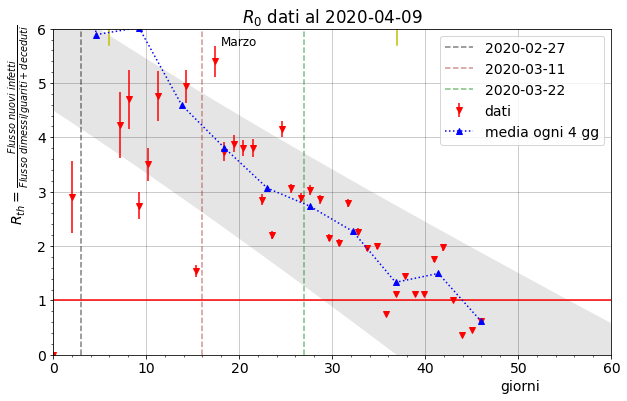

In [5]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))

a = df['variazione_totale_positivi']
b = np.gradient(df['dimessi_guariti'])+np.gradient(df['deceduti'])
Rth = a/b
err = Rth*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)

ax.errorbar(x, Rth, yerr=err, fmt='rv', label='dati')

day=16
mq,mqc = curve_fit(Line,x[x>day], Rth[x>day], p0=[-1,30], sigma=err[x>day])
mqe = np.sqrt(np.diag(mqc))
r2=r2_score(Rth[x>day] , Line(x[x>day], *mq))


# N=4
# y = np.convolve(Rth, np.ones((N,))/N, mode='valid')
# x = np.linspace(0, len(y), len(y))
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')


y, err = ManSdtSubArr(Rth, 4)
x = np.linspace(0, len(df['data']),len(y))
ax.errorbar(x, y, fmt='b^:', label='media ogni 4 gg')


x = np.linspace(0, 100, 100)
y = Line(x, *mq)
yp = y + 2*fitErr2(Line, x, mq, mqc)
yl = y - 2*fitErr2(Line, x, mq, mqc)
# ax.plot(x, y, 'r--', alpha=0.5, label='m = {0:.2f}±{1:.2f} \nq = {2:.1f}±{3:.1f} \nr2 = {4:.4f}'.format(mq[0], mqe[0], mq[1], mqe[1], r2) )
ax.fill_between(x, yl, yp, facecolor='grey', alpha=0.2)


day=3
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day =16
ax.axvline(day, color='brown', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day =27
ax.axvline(day, color='green', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
ax.axhline(1, color='red')

ax.set_title('$R_0$ dati al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th} = \frac{Flusso\ nuovi\ infetti}{Flusso\ dimessi/guariti +deceduti}$', horizontalalignment = 'left', y=0.4)
ax.legend(loc=0)
ymax = 6
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
ax.plot([6,6], [yptxt,ymax], 'y-')
ax.plot([6+31,6+31], [yptxt,ymax], 'y-')
# ax.plot([6+31+30,6+31+30], [yptxt,ymax], 'y-')
# ax.plot([6+31+30+31,6+31+30+31], [yptxt,ymax], 'y-')
ax.text(6+12, yptxt, 'Marzo', fontsize=12)
# ax.text(6+45, yptxt, 'Aprile', fontsize=12)
# ax.text(6+75, yptxt, 'Maggio', fontsize=12)
ax.set_xlim(0,60)
# ax.set_yscale('log')
plt.grid(color='k', linestyle='-', linewidth=1, alpha=0.2)
plt.minorticks_on()
plt.show()

a = 0.18 +/- 0.00
b = 28.31 +/- 0.24 
c = 17.90 +/- 0.34
R = 0.9636


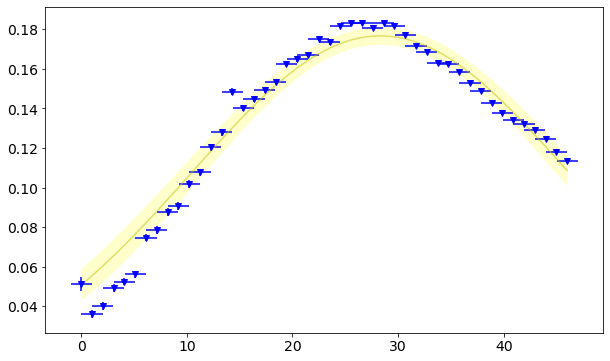

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
a = df['totale_positivi']
b = df['tamponi']
y = a/b
err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)
#GFPlot(y, ax, 4, 'b', label='casi', stat=True)

ax.errorbar(x, y, xerr=1, yerr=err, fmt='bv')

popt,pcov = curve_fit(Gauss3,x,y, sigma=err, p0=[max(y),len(x)/2, len(x)/4])
perr = np.sqrt(np.diag(pcov))
r2=r2_score(y, Gauss3(x, *popt))
print('a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                               popt[2], perr[2], r2))

y = Gauss3(x, *popt)
yp = Gauss3(x, *popt) + 3*fitErr3(Gauss3, x, popt, pcov)
yl = Gauss3(x, *popt) - 3*fitErr3(Gauss3, x, popt, pcov)
ax.plot(x, y, 'y-', alpha=0.5)
ax.fill_between(x, yl, yp, facecolor='yellow', alpha=0.2)
plt.show()

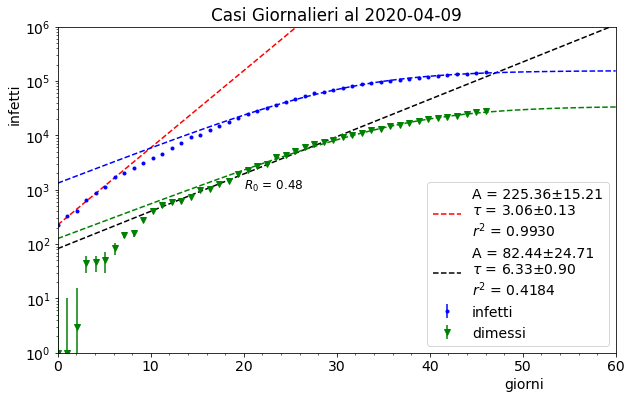

In [7]:

xd = x = np.linspace(0, len(df['data']), len(df['data']))
dfit = 0
min_exp_fit = 1+dfit
max_exp_fit = 7+dfit
y = df['totale_casi']
#y = df['deceduti']
yd = df['dimessi_guariti']
err = np.sqrt(np.gradient(y))
errd = np.sqrt(np.gradient(yd))
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x, y, yerr=err, fmt='b.', label='infetti')
ax.errorbar(xd, yd, yerr=err, fmt='gv', label='dimessi')

xf = x[(min_exp_fit<x) & (x<max_exp_fit)]
yf = y[(min_exp_fit<x) & (x<max_exp_fit)]
ef = err[(min_exp_fit<x) & (x<max_exp_fit)]
depi = 9
xdf = xd[(min_exp_fit+depi<x) & (x<max_exp_fit+depi)]
ydf = yd[(min_exp_fit+depi<x) & (x<max_exp_fit+depi)]
edf = errd[(min_exp_fit+depi<x) & (x<max_exp_fit+depi)]

popt_e,pcov_e = curve_fit(Exp,xf, yf, p0=[300,3], sigma=ef)
popt_d,pcov_d = curve_fit(Exp,xdf, ydf, p0=[300,3], sigma=edf)
#popt_e,pcov_e = curve_fit(Infected,x[x<max_exp_fit], y[x<max_exp_fit], p0=[300.,1.,1.], sigma=err[x<max_exp_fit])
perr_e = np.sqrt(np.diag(pcov_e))
r2_e=r2_score(yf, Exp(xf, *popt_e))
perr_d = np.sqrt(np.diag(pcov_d))
r2_d=r2_score(yf, Exp(xdf, *popt_d))
#r2_e=r2_score(y[x<max_exp_fit], Infected(x[x<max_exp_fit], *popt_e))


popt_l,pcov_l = curve_fit(Logistic,x[x>16], y[x>16], p0=[130000.,1., 0.01], sigma=err[x>16]) # [130000.,.2, 30.]
perr_l = np.sqrt(np.diag(pcov_l))
r2_l=r2_score(y, Logistic(x, *popt_l))

popt_ld,pcov_ld = curve_fit(Logistic,xd[xd>16], yd[xd>16], p0=[3000.,1., 0.01], sigma=errd[xd>16])
perr_ld = np.sqrt(np.diag(pcov_ld))
r2_ld=r2_score(yd, Logistic(xd, *popt_ld))

x=np.linspace(0,60,60)
ax.plot(x, Exp(x, *popt_e), 'r--', label=('A = {0:.2f}±{1:.2f}\n'+r'$\tau$ = {2:.2f}±{3:.2f}'+\
'\n$r^2$ = {4:.4f}').format(popt_e[0], perr_e[0], popt_e[1], perr_e[1], r2_e))
ax.plot(x, Exp(x, *popt_d), 'k--', label=('A = {0:.2f}±{1:.2f}\n'+r'$\tau$ = {2:.2f}±{3:.2f}'+\
'\n$r^2$ = {4:.4f}').format(popt_d[0], perr_d[0], popt_d[1], perr_d[1], r2_d))
# ax.plot(x, Infected(x, *popt_e), 'r--', label='$I_0$ = {0:.2f}±{1:.2f}\n$\mu$ = {2:.2f}±{3:.2f} \
# \n$R_0$ = {4:.2f}±{5:.2f}\n$r^2$ = {6:.2f}'.format(popt_e[0], perr_e[0], popt_e[1], perr_e[1], popt_e[2], perr_e[2], r2_e))
ax.plot(x, Logistic(x, *popt_l), 'b--') #, label='L = {0:.0f} +/- {1:.0f}\nk = {2:.3f} +/- {3:.4f} \
# \nx0 = {4:.2f} +/- {5:.2f}\n$r^2$ = {6:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2], r2_l))
ax.plot(x, Logistic(x, *popt_ld), 'g--') #, label='L = {0:.0f} +/- {1:.0f}\nk = {2:.3f} +/- {3:.4f} \
# \nx0 = {4:.2f} +/- {5:.2f}\n$r^2$ = {6:.2f}'.format(popt_ld[0], perr_ld[0], popt_ld[1], perr_ld[1], popt_ld[2], perr_ld[2], r2_ld))

ax.text(20, 1000, '$R_0$ = {0:.2f}'.format(popt_e[1]/popt_d[1]), fontsize=12)

ax.set_xlim(0,60)
ax.set_ylim(1,1e6)
ax.set_title('Casi Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.legend(loc=4)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('infetti', horizontalalignment = 'left', y=0.7)
ax.set_yscale('log')
plt.minorticks_on()
plt.show()


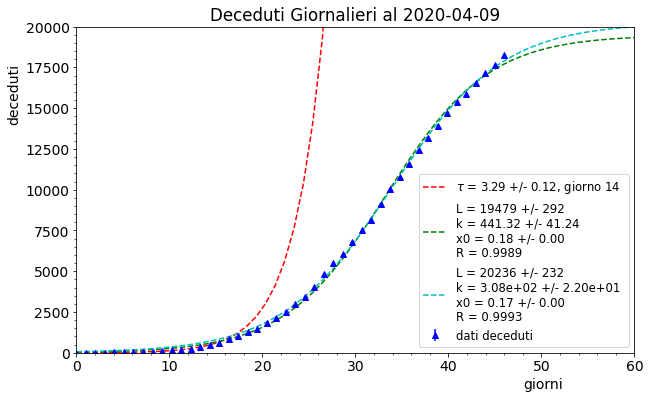

In [8]:

x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz
max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
err = np.sqrt(np.gradient(df['deceduti']))

ax.errorbar(x, df['deceduti'], yerr=err, fmt='b^', label='dati deceduti')

#ax.plot(x, df['deceduti'], 'b.', label='dati deceduti')
min_log_fit = 8
popt_l,pcov_l = curve_fit(Logistic,x[x>min_log_fit], df['deceduti'][x>min_log_fit], 
                          p0=[4000.,1., 0.01], sigma=err[x>min_log_fit])
perr_l = np.sqrt(np.diag(pcov_l))
popt_l_0,pcov_l_0 = curve_fit(Logistic,x[x>min_log_fit], df['deceduti'][x>min_log_fit], 
                          p0=[4000.,1., .01])
perr_l_0 = np.sqrt(np.diag(pcov_l_0))
r2_l=r2_score(df['deceduti'], Logistic(x, *popt_l))
r2_l_0=r2_score(df['deceduti'], Logistic(x, *popt_l_0))

x=np.linspace(0,60,60)
ax.plot(x, Exp(x, *popt_e), 'r--', label=r'$\tau$ = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2], r2_l))

ax.plot(x, Logistic(x, *popt_l_0), 'c--', label='L = {0:.0f} +/- {1:.0f}\nk = {2:.2e} +/- {3:.2e} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_0[0], perr_l_0[0], popt_l_0[1], perr_l_0[1], popt_l_0[2], perr_l_0[2], r2_l_0))
#ax.set_yscale('log')
ax.set_xlim(0,60)
ax.set_ylim(0,20000)
ax.legend(loc=4, prop={'size':'small'})
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()

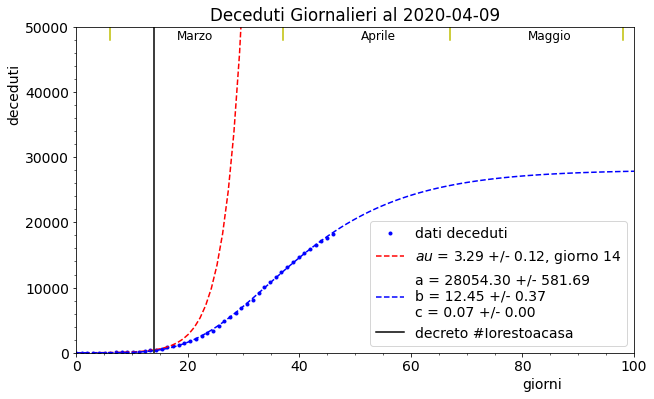

In [9]:
x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz

max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
max_gom_fit = 16
err = np.sqrt(np.gradient(df['deceduti']))
popt_g,pcov_g = curve_fit(Gompertz,x[x>max_gom_fit], df['deceduti'][x>max_gom_fit], p0=[4500.,20., 0.01], sigma=err[x>max_gom_fit])
perr_g = np.sqrt(np.diag(pcov_g))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['deceduti'], 'b.', label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='$\tau$ = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))


#ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(0,50000)
ax.plot([14,14], [0,50000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [48000,50000], 'y-')
ax.plot([6+31,6+31], [48000,50000], 'y-')
ax.plot([6+31+30,6+31+30], [48000,50000], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [48000,50000], 'y-')
ax.text(6+12, 48000, 'Marzo', fontsize=12)
ax.text(6+45, 48000, 'Aprile', fontsize=12)
ax.text(6+75, 48000, 'Maggio', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


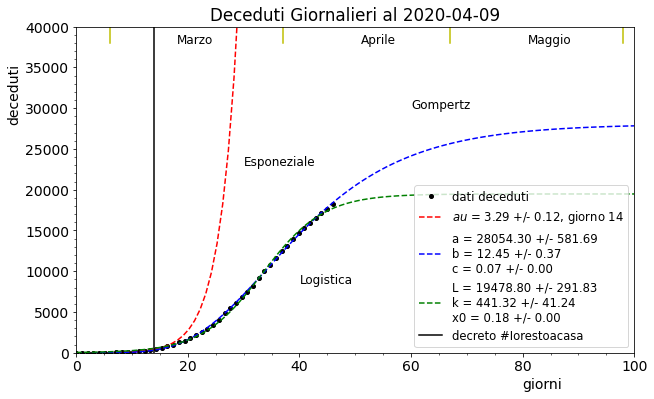

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='$\tau$ = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))

#ax.set_yscale('log')
ymax = 40000
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
ax.set_xlim(0,100)
ax.plot([14,14], [0,ymax], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [yptxt,ymax], 'y-')
ax.plot([6+31,6+31], [yptxt,ymax], 'y-')
ax.plot([6+31+30,6+31+30], [yptxt,ymax], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [yptxt,ymax], 'y-')
ax.text(6+12, yptxt, 'Marzo', fontsize=12)
ax.text(6+45, yptxt, 'Aprile', fontsize=12)
ax.text(6+75, yptxt, 'Maggio', fontsize=12)

#ax.plot([6,6], [28000,30000], 'y-')
#ax.plot([6+31,6+31], [28000,30000], 'y-')
#ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
#ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
#ax.text(6+12, 28000, 'Marzo', fontsize=12)
##ax.text(6+45, 28000, 'Aprile', fontsize=12)
#ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.text(30, 23000, 'Esponeziale', fontsize=12)
ax.text(60, 30000, 'Gompertz', fontsize=12)
ax.text(40, 8500, 'Logistica', fontsize=12)
ax.legend(loc=4, prop={'size':'small'})
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


L = 21506 +/- 172
k = 184.50 +/- 9.09 
x0 = 0.15 +/- 0.00
R = 0.9979
L = 155398 +/- 1883
k = 116.66 +/- 8.20 
x0 = 0.15 +/- 0.00
R = 0.9988
a = 25832.45 +/- 470.85
b = 15.21 +/- 0.76 
c = 0.08 +/- 0.00
R = 0.9996
a = 191201.58 +/- 2254.87
b = 9.84 +/- 0.22 
c = 0.08 +/- 0.00
R = 0.9996


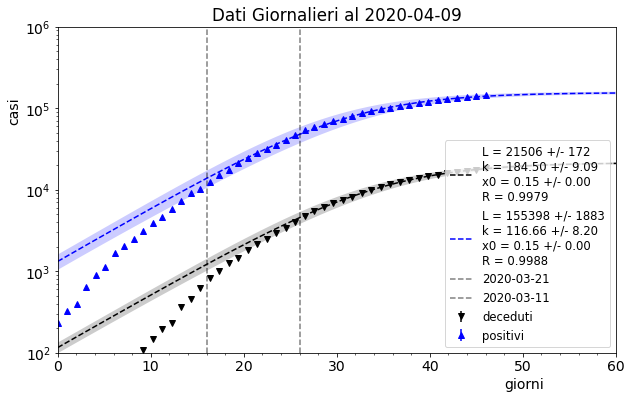

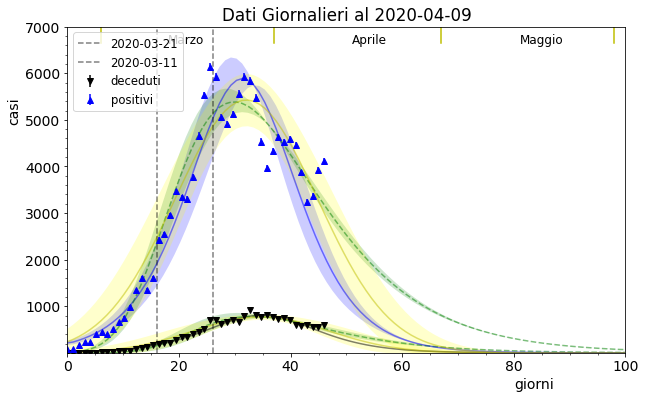

In [11]:
T_days =  len(df)
x = np.linspace(0, T_days, T_days)
fit_cut_l = 26
fit_cut_lc = 16


fig, ax = plt.subplots(figsize=(10,6))

y_int_IT = df['deceduti']
y2_int_IT = df['totale_casi']
y3_int_IT = df['terapia_intensiva']

err_IT = np.sqrt(np.gradient(y_int_IT,x))
err2_IT = np.sqrt(np.gradient(y2_int_IT,x))
err3_IT = np.sqrt(np.gradient(y3_int_IT,x))

ax.errorbar(x, y_int_IT, yerr=err_IT, fmt='kv', label='deceduti')
ax.errorbar(x, y2_int_IT, yerr=err2_IT, fmt='b^', label='positivi')
# ax.errorbar(x, y3_int_IT, yerr=err3_IT, fmt='r.', label='terapia intensiva')


popt_l_i,pcov_l_i = curve_fit(Logistic,x[x>fit_cut_l], y_int_IT[x>fit_cut_l], 
                              sigma=err_IT[x>fit_cut_l], p0=[10000.,1, 0.01])
perr_l_i = np.sqrt(np.diag(pcov_l_i))
r2_l_i=r2_score(y_int_IT, Logistic(x, *popt_l_i))

print('L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1],
                                                popt_l_i[2], perr_l_i[2], r2_l_i))

popt_l_ic,pcov_l_ic = curve_fit(Logistic,x[x>fit_cut_lc], y2_int_IT[x>fit_cut_lc], 
                                sigma=err2_IT[x>fit_cut_lc], p0=[100000.,1, .01])
perr_l_ic = np.sqrt(np.diag(pcov_l_ic))
r2_l_ic=r2_score(y2_int_IT, Logistic(x, *popt_l_ic))
print('L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_ic[0], perr_l_ic[0], popt_l_ic[1], perr_l_ic[1],
                                                popt_l_ic[2], perr_l_ic[2], r2_l_ic))
popt_g_i,pcov_g_i = curve_fit(Gauss3,x[x>fit_cut_l], np.gradient(y_int_IT[x>fit_cut_l], x[x>fit_cut_l]), 
                              sigma=err_IT[x>fit_cut_l], p0=[1000.,20, 10.])
popt_g_ic,pcov_g_ic = curve_fit(Gauss3,x[x>fit_cut_lc], np.gradient(y2_int_IT[x>fit_cut_lc], x[x>fit_cut_lc]), 
                              sigma=err_IT[x>fit_cut_lc], p0=[100000.,20, 10.])

# popt_l_it,pcov_l_it = curve_fit(Logistic,x[x>fit_cut_lc], y3_int_IT[x>fit_cut_lc], 
#                                 p0=[1000.,0.5, 20.], sigma=err3_IT[x>fit_cut_lc])
# perr_l_it = np.sqrt(np.diag(pcov_l_it))
#r2_g_i=r2_score(np.gradient(y_int_IT[x>fit_cut_l], x[x>fit_cut_l]), Logistic(x, *popt_l_i))
#r2_g_ic=r2_score(y_int_IT, Logistic(x, *popt_l_i))
# r2_l_it=r2_score(y3_int_IT , Logistic(x, *popt_l_it))
######################################
popt_geo_i,pcov_geo_i = curve_fit(Gompertz,x[x>fit_cut_l], y_int_IT[x>fit_cut_l], p0=[4500.,20., 0.01],
                                  sigma=err_IT[x>fit_cut_l])
perr_geo_i = np.sqrt(np.diag(pcov_geo_i))
r2_geo_i=r2_score(y_int_IT[x>fit_cut_l], Gompertz(x[x>fit_cut_l], *popt_geo_i))
print('a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_geo_i[0], perr_geo_i[0], popt_geo_i[1], perr_geo_i[1], 
                                               popt_geo_i[2], perr_geo_i[2], r2_geo_i))

popt_geo_ic,pcov_geo_ic = curve_fit(Gompertz,x[x>fit_cut_lc], y2_int_IT[x>fit_cut_lc], p0=[150000.,20., 0.01],
                                    sigma=err2_IT[x>fit_cut_lc])
perr_geo_ic = np.sqrt(np.diag(pcov_geo_ic))
r2_geo_ic=r2_score(y2_int_IT[x>fit_cut_lc], Gompertz(x[x>fit_cut_lc], *popt_geo_ic))
print('a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_geo_ic[0], perr_geo_ic[0], popt_geo_ic[1], perr_geo_ic[1], 
                                               popt_geo_ic[2], perr_geo_ic[2], r2_geo_ic))

#######################################

x = np.linspace(0, 100, 100)

# ax.plot(x, Gompertz(x, *popt_g_i), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
# \nc = {4:.2f} +/- {5:.2f}'.format(popt_g_i[0], perr_g_i[0], popt_g_i[1], perr_g_i[1], popt_g_i[2], perr_g_i[2]))

ax.plot(x, Logistic(x, *popt_l_i), 'k--', label='L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1], 
                                                popt_l_i[2], perr_l_i[2], r2_l_i))
yp = Logistic(x, *popt_l_i) + 3*fitErr3(Logistic, x, popt_l_i, pcov_l_i)
yl = Logistic(x, *popt_l_i) - 3*fitErr3(Logistic, x, popt_l_i, pcov_l_i)
ax.fill_between(x, yl, yp, facecolor='black', alpha=0.2)

# ax.fill_between(x, 0, Logistic(x, *popt_l_i), facecolor='black', alpha=0.3)

ax.plot(x, Logistic(x, *popt_l_ic), 'b--', label='L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_ic[0], perr_l_ic[0], popt_l_ic[1], perr_l_ic[1],
                                                popt_l_ic[2], perr_l_ic[2], r2_l_ic))
yp = Logistic(x, *popt_l_ic) + 3*fitErr3(Logistic, x, popt_l_ic, pcov_l_ic)
yl = Logistic(x, *popt_l_ic) - 3*fitErr3(Logistic, x, popt_l_ic, pcov_l_ic)
ax.fill_between(x, yl, yp, facecolor='blue', alpha=0.2)
# ax.plot(x, Logistic(x, *popt_l_it), 'r--', label='L = {0:.0f} +/- {1:.0f}\nk = {2:.2f} +/- {3:.2f} \
# \nx0 = {4:.2f} +/- {5:.2f}\nR = {6:.4f}'.format(popt_l_it[0], perr_l_it[0], popt_l_it[1], perr_l_it[1],
#                                                 popt_l_it[2], perr_l_it[2], r2_l_it))
# ax.fill_between(x, 0, Logistic(x, *popt_l_it), facecolor='red', alpha=0.5)

ax.axvline(fit_cut_l, color='black', linestyle='--', label='{:s}'.format(df.iloc[fit_cut_l, 0][0:10]), alpha=0.5)
ax.axvline(fit_cut_lc, color='black', linestyle='--', label='{:s}'.format(df.iloc[fit_cut_lc, 0][0:10]), alpha=0.5)


ymax = 1e6
yptxt = ymax - ymax*0.05
ax.set_ylim(100,ymax)
ax.set_xlim(0,60)

ax.set_title('Dati Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
ax.set_yscale('log')
plt.minorticks_on()
plt.legend(loc=4, prop={'size':'small'})
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, T_days, T_days)

ax.errorbar(x, np.gradient(y_int_IT,x), yerr=err_IT, fmt='kv', label='deceduti')

ax.errorbar(x, np.gradient(y2_int_IT,x), yerr=err2_IT, fmt='b^', label='positivi')

# ax.errorbar(x, np.gradient(y3_int_IT,x), yerr=err3_IT, fmt='r^', label='t. intesiva')




x = np.linspace(0, 100, 100)

#y = np.gradient(Logistic(x, *popt_l_i), x)
y = dLogistic(x, *popt_l_i)
yp = dLogistic(x, *popt_l_i) + dLogistic(x, *popt_l_i)*3*fitErr3(Logistic, x, popt_l_i, pcov_l_i)
yl = dLogistic(x, *popt_l_i) - dLogistic(x, *popt_l_i)*3*fitErr3(Logistic, x, popt_l_i, pcov_l_i)
ax.plot(x, y, 'k-', alpha=0.5)
y = np.gradient(Gompertz(x, *popt_geo_i), x)
yp = np.gradient(Gompertz(x, *popt_geo_i) + 3*fitErr3(Gompertz, x, popt_geo_i, pcov_geo_i),x)
yl = np.gradient(Gompertz(x, *popt_geo_i) - 3*fitErr3(Gompertz, x, popt_geo_i, pcov_geo_i),x)
ax.plot(x, y, 'g--', alpha=0.5)
ax.fill_between(x, yl, yp, facecolor='green', alpha=0.2)
y = Gauss3(x, *popt_g_i)
yp = Gauss3(x, *popt_g_i) + 3*fitErr3(Gauss3, x, popt_g_i, pcov_g_i)
yl = Gauss3(x, *popt_g_i) - 3*fitErr3(Gauss3, x, popt_g_i, pcov_g_i)
ax.plot(x, y, 'y-', alpha=0.5)
ax.fill_between(x, yl, yp, facecolor='yellow', alpha=0.2)

ax.plot(x, np.gradient(Logistic(x, *popt_l_ic), x), 'b-', alpha=0.5)

y = np.gradient(Logistic(x, *popt_l_ic), x)
yp = np.gradient(Logistic(x, *popt_l_ic) + 3*fitErr3(Logistic, x, popt_l_ic, pcov_l_ic),x)
yl = np.gradient(Logistic(x, *popt_l_ic) - 3*fitErr3(Logistic, x, popt_l_ic, pcov_l_ic),x)
ax.fill_between(x, yl, yp, facecolor='blue', alpha=0.2)
y = np.gradient(Gompertz(x, *popt_geo_ic), x)
yp = np.gradient(Gompertz(x, *popt_geo_ic) + 3*fitErr3(Gompertz, x, popt_geo_ic, pcov_geo_ic),x)
yl = np.gradient(Gompertz(x, *popt_geo_ic) - 3*fitErr3(Gompertz, x, popt_geo_ic, pcov_geo_ic),x)
ax.plot(x, y, 'g--', alpha=0.5)
ax.fill_between(x, yl, yp, facecolor='green', alpha=0.2)
y = Gauss3(x, *popt_g_ic)
yp = Gauss3(x, *popt_g_ic) + 3*fitErr3(Gauss3, x, popt_g_ic, pcov_g_ic)
yl = Gauss3(x, *popt_g_ic) - 3*fitErr3(Gauss3, x, popt_g_ic, pcov_g_ic)
ax.plot(x, y, 'y-', alpha=0.5)
ax.fill_between(x, yl, yp, facecolor='yellow', alpha=0.2)



ymax = 7000
yptxt = ymax - ymax*0.05
ax.set_ylim(1,ymax)
ax.set_xlim(0,100)
ax.plot([6,6], [yptxt,ymax], 'y-')
ax.plot([6+31,6+31], [yptxt,ymax], 'y-')
ax.plot([6+31+30,6+31+30], [yptxt,ymax], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [yptxt,ymax], 'y-')
ax.text(6+12, yptxt, 'Marzo', fontsize=12)
ax.text(6+45, yptxt, 'Aprile', fontsize=12)
ax.text(6+75, yptxt, 'Maggio', fontsize=12)
ax.axvline(fit_cut_l, color='black', linestyle='--', label='{:s}'.format(df.iloc[fit_cut_l, 0][0:10]), alpha=0.5)
ax.axvline(fit_cut_lc, color='black', linestyle='--', label='{:s}'.format(df.iloc[fit_cut_lc, 0][0:10]), alpha=0.5)

ax.set_title('Dati Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)

ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
#ax.set_yscale('log')
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'small'})
plt.show()
save_popt_l_i=popt_l_i

a = 5738.69 +/- 269.20
b = 32.10 +/- 0.75   
c = 12.83 +/- 0.62
$R^2$ = 0.9599
a = 5823.14 +/- 175.37
b = 34.97 +/- 0.49   
c = 11.65 +/- 0.36
$R^2$ = 0.9904
a = 6130.26 +/- 149.60
b = 39.67 +/- 0.75   
c = 13.73 +/- 0.45
$R^2$ = 0.9956


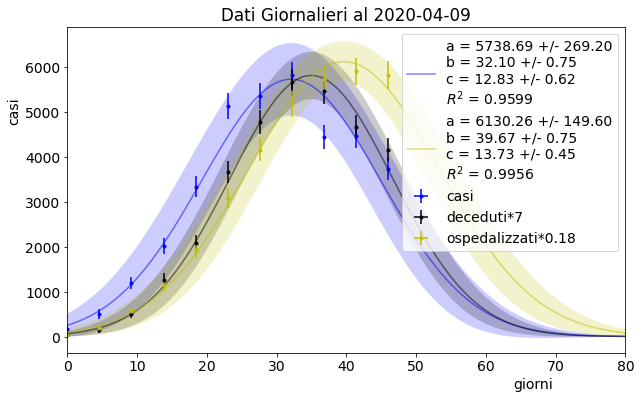

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
T_days =  len(df)
x = np.linspace(0, T_days, T_days)

# a = df['totale_positivi']
# b = df['tamponi']
# y = a/b
# err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)

mediasu = 4
GFPlot(np.gradient(df['totale_casi']), ax, mediasu, 'b', label='casi', stat=True)
GFPlot(np.gradient(df['deceduti'])*7, ax, mediasu, 'k', label='deceduti*7')
GFPlot(df['totale_ospedalizzati']*0.18, ax, mediasu, 'y', label='ospedalizzati*0.18', stat=True)
plt.title('Dati Giornalieri al '+str(np.array(df['data'])[-1])[0:10])
plt.xlabel('giorni', horizontalalignment = 'left', x=0.8)
plt.ylabel('casi', horizontalalignment = 'left', y=0.7)
plt.xlim(0,80)
plt.legend()
plt.show()

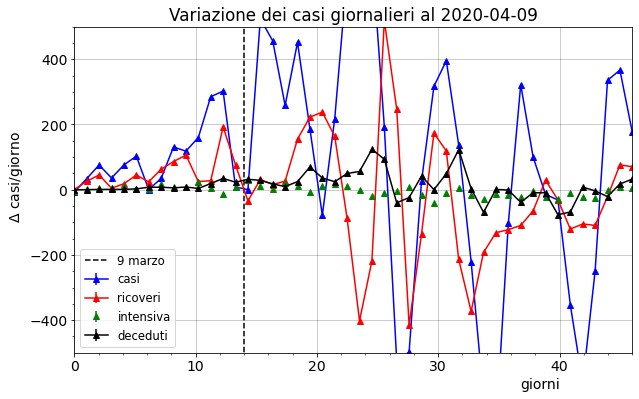

2020-03-09T18:00:00


In [13]:
# T_days =  len(df)
#from scipy.interpolate import spline
x = np.linspace(0, T_days, T_days)
fit_cut_l = 16
fit_cut_g = 0
fig, ax = plt.subplots(figsize=(10,6))

# popt_l,pcov_l = curve_fit(Logistic,x[x>fit_cut_l], df['totale_casi'][x>fit_cut_l], p0=[100000.,0.2, 25.], sigma=yerr[x>fit_cut_l])
# perr_l = np.sqrt(np.diag(pcov_l))
# ax.plot(x, np.gradient(Logistic(x, *popt_l),x), 'b--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
# \nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))

y = np.gradient(np.gradient(df['totale_casi'],x), x)
yerr = 0
ax.errorbar(x, y, yerr=yerr, fmt='b^-', label='casi')
y = np.gradient(np.gradient(df['ricoverati_con_sintomi'],x),x)
yerr = 0
ax.errorbar(x, y, yerr=yerr, fmt='r^-', label='ricoveri')
y = np.gradient(np.gradient(df['terapia_intensiva'],x),x)
yerr = 0
ax.errorbar(x, y, yerr=yerr, fmt='g^', label='intensiva')
y = np.gradient(np.gradient(df['deceduti'],x),x)
yerr = 0
ax.errorbar(x, y, yerr=yerr, fmt='k^-', label='deceduti')

ax.arrow(16,900, 0, 300)
ax.plot([14,14], [-900,900], 'k--', label='9 marzo')
# ax.plot([21,21], [250,900], 'k--', label='+5 giorni')
# ax.plot([26,26], [150,900], 'k--', label='+10 giorni')
#ax.set_yscale('log')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('$\Delta$ casi/giorno', horizontalalignment = 'left', y=0.4)
ax.set_title('Variazione dei casi giornalieri al '+str(np.array(df['data'])[-1][0:10]))
ax.set_ylim(-500,500)
ax.set_xlim(0,T_days)
plt.minorticks_on()
plt.legend(loc=3, prop={'size':'small'})
plt.grid(color='k', linestyle='-', linewidth=1, alpha=0.2)
plt.show()
print (df.iloc[14,0])

In [14]:
# world data
# https://github.com/CSSEGISandData/COVID-19
from datetime import datetime, timedelta
yesterday = datetime.now() - timedelta(days = 1)
data_sel = datetime.today().strftime('%Y-%m-%d')
#data_sel = '2020-04-07'

try:
  url_csv_file = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{:s}.xlsx".format(data_sel)
  dw = pd.read_excel(url_csv_file)
except:
  yesterday = datetime.now() - timedelta(days = 1)
  data_sel = yesterday.strftime('%Y-%m-%d')
  url_csv_file = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{:s}.xlsx".format(data_sel)
  dw = pd.read_excel(url_csv_file)
dw.tail()


,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
9712,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
9713,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
9714,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
9715,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0
9716,2020-03-21,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


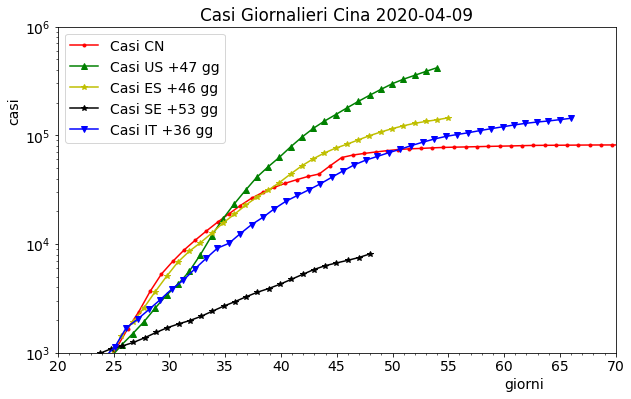

In [15]:
from scipy import integrate
from matplotlib.ticker import MaxNLocator
China = dw.loc[(dw['geoId'] == 'CN')].sort_values(by="dateRep")
Italy = dw.loc[(dw['geoId'] == 'IT')].sort_values(by="dateRep")
USA   = dw.loc[(dw['geoId'] == 'US')].sort_values(by="dateRep")
Spain = dw.loc[(dw['geoId'] == 'ES')].sort_values(by="dateRep")
Svezia = dw.loc[(dw['geoId'] == 'SE')].sort_values(by="dateRep")
T_days =  len(China)
ita_offset = 36
usa_offset = 47
spa_offset = 46
sve_offset = 53
x = np.linspace(0, T_days, T_days)
fig, ax = plt.subplots(figsize=(10,6))
y_int_IT = integrate.cumtrapz(Italy['cases'], x, initial=0)
y_int_US = integrate.cumtrapz(USA['cases'], x, initial=0)
y_int_ES = integrate.cumtrapz(Spain['cases'], x, initial=0)
y_int_SE = integrate.cumtrapz(Svezia['cases'], x, initial=0)


y_int_CN = integrate.cumtrapz(China['cases'], x, initial=0)
ax.plot(x, y_int_CN, 'r.-', label='Casi CN')
ax.plot(x-usa_offset, y_int_US, 'g^-', label='Casi US +{:.0f} gg'.format(usa_offset))
ax.plot(x-spa_offset, y_int_ES, 'y*-', label='Casi ES +{:.0f} gg'.format(spa_offset))
ax.plot(x-sve_offset, y_int_SE, 'k*-', label='Casi SE +{:.0f} gg'.format(sve_offset))
#ax.plot(x-ita_offset, y_int_IT, 'bv-', label='Casi IT')
x = np.linspace(56-ita_offset, len(df['data'])+56-ita_offset, len(df['data']))
ax.plot(x, df['totale_casi'], 'bv-', label='Casi IT +{:.0f} gg'.format(ita_offset))
ymax = 1000000
yptxt = ymax - ymax*0.05
ax.set_ylim(1000,ymax)
ax.set_xlim(20,70)
ax.set_title('Casi Giornalieri Cina '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
ax.set_yscale('log')
day=ita_offset-16
#ax.axvline(day, label='{:s}'.format(Italy.iloc[day, 0].strftime("%y-%b-%Y")))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'medium'})
plt.show()

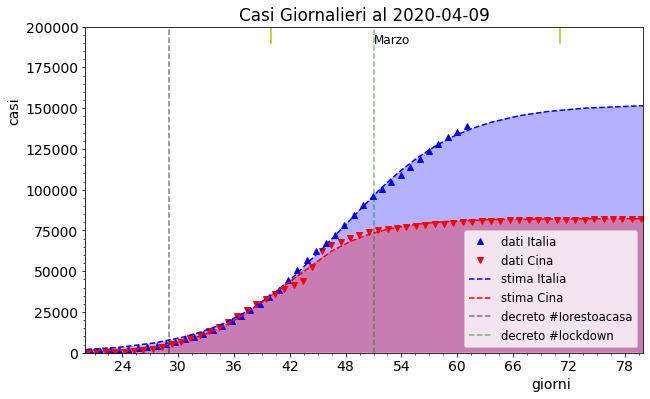

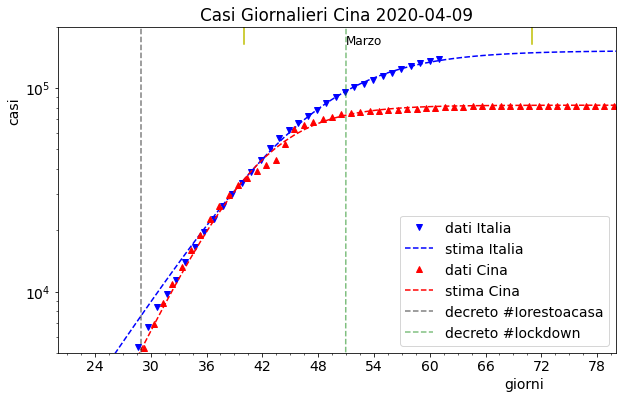

In [16]:
#China = dw.loc[(dw['GeoId'] == 'CN')].sort_values(by="DateRep")
#Italy = dw.loc[(dw['GeoId'] == 'IT')].sort_values(by="DateRep")
T_days =  len(China)
x = np.linspace(0, T_days, T_days)
ita_offset = 40
fit_cut = 40+30
fig, ax = plt.subplots(figsize=(10,6))

y_int_IT = integrate.cumtrapz(Italy['cases'], x, initial=0)
ax.plot(x-ita_offset, y_int_IT, 'b^', label='dati Italia')
y_int_CN = integrate.cumtrapz(China['cases'], x, initial=0)
ax.plot(x, y_int_CN, 'rv', label='dati Cina')

popt_l_c,pcov_l_c = curve_fit(Logistic,x, y_int_CN, p0=[80000.,10, 0.01])
perr_l_c = np.sqrt(np.diag(pcov_l_c))
popt_g_c,pcov_g_c = curve_fit(Gompertz,x, y_int_CN, p0=[80000.,200., 0.14])
perr_g_c = np.sqrt(np.diag(pcov_g_c))
popt_l_i,pcov_l_i = curve_fit(Logistic,(x-ita_offset)[x>fit_cut], y_int_IT[x>fit_cut], p0=[80000.,10, 0.01])
perr_l_i = np.sqrt(np.diag(pcov_l_i))
popt_g_i,pcov_g_i = curve_fit(Gompertz,(x-ita_offset), y_int_IT, p0=[2000000.,15., 0.03])
perr_g_i = np.sqrt(np.diag(pcov_g_i))



x = np.linspace(-ita_offset, T_days, T_days+ita_offset)
# ax.plot(x, Gompertz(x, *popt_g_i), 'c--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
# \nc = {4:.2f} +/- {5:.2f}'.format(popt_g_i[0], perr_g_i[0], popt_g_i[1], perr_g_i[1], popt_g_i[2], perr_g_i[2]))
ax.plot(x, Logistic(x, *popt_l_i), 'b--', label='stima Italia' \
#        , label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
#        \nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1], popt_l_i[2], perr_l_i[2])\
        )
ax.fill_between(x, 0, Logistic(x, *popt_l_i), facecolor='blue', alpha=0.3)

#x = np.linspace(0+57, len(df['data'])+57, len(df['data']))
#ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
# ax.plot(x, Gompertz(x, *popt_g_c), 'g--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
# \nc = {4:.2f} +/- {5:.2f}'.format(popt_g_c[0], perr_g_c[0], popt_g_c[1], perr_g_c[1], popt_g_c[2], perr_g_c[2]))
ax.plot(x, Logistic(x, *popt_l_c), 'r--', label='stima Cina' \
        # , label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
        # \nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_c[0], perr_l_c[0], popt_l_c[1], perr_l_c[1], popt_l_c[2], perr_l_c[2])\
        )
ax.fill_between(x, 0,  Logistic(x, *popt_l_c), facecolor='red', alpha=0.3)

ymax = 200000
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
#ax.set_ylim(5000,100000)

ax.set_xlim(20,80)
ax.set_title('Casi Giornalieri al '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot([29,29], [0,ymax], 'k--', label='decreto #Iorestoacasa', alpha=0.5)
ax.plot([29+22,29+22], [0,ymax], 'g--', label='decreto #lockdown', alpha=0.5)
ax.plot([T_days-ita_offset-21,T_days-ita_offset-21], [yptxt,ymax], 'y-')
ax.plot([T_days-ita_offset+10,T_days-ita_offset+10], [yptxt,ymax], 'y-')
ax.text(T_days-ita_offset-10, yptxt, 'Marzo', fontsize=12)

plt.minorticks_on()
plt.legend(loc=4, prop={'size':'small'})
#ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, T_days, T_days)
y_int_IT = integrate.cumtrapz(Italy['cases'], x, initial=0)
ax.plot(x-ita_offset, y_int_IT, 'bv', label='dati Italia')
ax.plot(x, Logistic(x, *popt_l_i), 'b--', label='stima Italia')
y_int_CN = integrate.cumtrapz(China['cases'], x, initial=0)
ax.plot(x, y_int_CN, 'r^', label='dati Cina')
ax.plot(x, Logistic(x, *popt_l_c), 'r--', label='stima Cina')

#x = np.linspace(0+56-ita_offset, len(df['data'])+56-ita_offset, len(df['data']))
#ax.plot(x, df['totale_casi'], 'bv-', label='Casi IT')
ymax = 200000
yptxt = ymax - ymax*0.18
ax.set_ylim(5000,ymax)
ax.set_xlim(20,80)
ax.set_title('Casi Giornalieri Cina '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)

ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot([29,29], [0,ymax], 'k--', label='decreto #Iorestoacasa', alpha=0.5)
ax.plot([29+1,29+22], [0,ymax], 'g--', label='decreto #lockdown', alpha=0.5)
ax.plot([T_days-ita_offset-21,T_days-ita_offset-21], [yptxt,ymax], 'y-')
ax.plot([T_days-ita_offset+10,T_days-ita_offset+10], [yptxt,ymax], 'y-')
ax.text(T_days-ita_offset-10, yptxt, 'Marzo', fontsize=12)


plt.minorticks_on()

plt.legend(loc=4, prop={'size':'medium'})
plt.show()




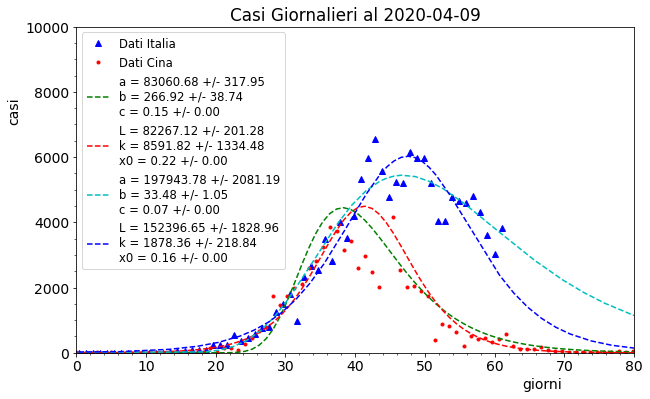

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, T_days, T_days)
ax.plot(x-ita_offset, Italy['cases'], 'b^', label='Dati Italia')
ax.plot(x,China['cases'], 'r.', label='Dati Cina')
ax.plot(x, np.gradient(Gompertz(x, *popt_g_c),x), 'g--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_c[0], perr_g_c[0], popt_g_c[1], perr_g_c[1], popt_g_c[2], perr_g_c[2]))
ax.plot(x, np.gradient(Logistic(x, *popt_l_c),x), 'r--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_c[0], perr_l_c[0], popt_l_c[1], perr_l_c[1], popt_l_c[2], perr_l_c[2]))
x = np.linspace(-ita_offset, T_days, T_days+ita_offset)
ax.plot(x, np.gradient(Gompertz(x, *popt_g_i),x), 'c--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_i[0], perr_g_i[0], popt_g_i[1], perr_g_i[1], popt_g_i[2], perr_g_i[2]))
ax.plot(x, np.gradient(Logistic(x, *popt_l_i), x), 'b--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1], popt_l_i[2], perr_l_i[2]))
ax.set_ylim(0,10000)
ax.set_xlim(0,80)

ax.set_title('Casi Giornalieri al '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'small'})
plt.show()

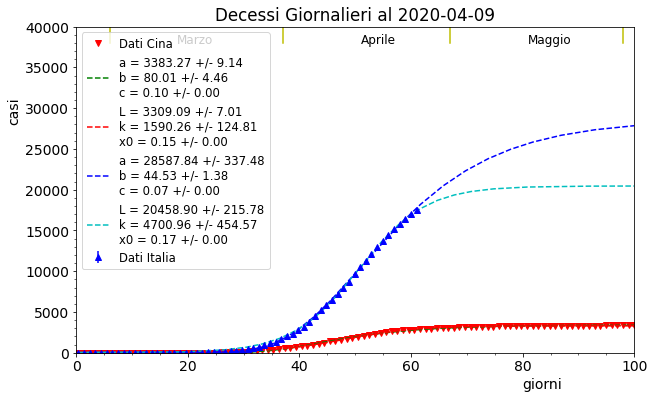

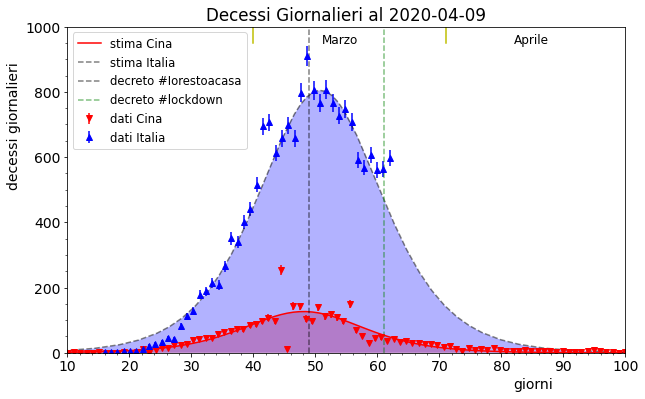

In [18]:
#China = dw.loc[(dw['GeoId'] == 'CN')].sort_values(by="DateRep")
#Italy = dw.loc[(dw['GeoId'] == 'IT')].sort_values(by="DateRep")
T_days =  len(China)
x = np.linspace(0, T_days, T_days)
ita_offset = 40
fit_cut_l = 40+36
fit_cut_g = 0
fig, ax = plt.subplots(figsize=(10,6))
y_int_IT = integrate.cumtrapz(Italy['deaths'], x, initial=0)
err_IT = np.sqrt(y_int_IT)
ax.errorbar(x-ita_offset, y_int_IT, yerr=err_IT, fmt='b^', label='Dati Italia')
y_int_CN = integrate.cumtrapz(China['deaths'], x, initial=0)
err_CN = np.sqrt(y_int_CN)
ax.plot(x, y_int_CN, 'rv', label='Dati Cina')


popt_l_c,pcov_l_c = curve_fit(Logistic,x, y_int_CN, p0=[80000.,10, 0.01])
perr_l_c = np.sqrt(np.diag(pcov_l_c))
popt_g_c,pcov_g_c = curve_fit(Gompertz,x, y_int_CN, p0=[80000.,200., 0.14])
perr_g_c = np.sqrt(np.diag(pcov_g_c))
popt_l_i,pcov_l_i = curve_fit(Logistic,(x-ita_offset)[x>fit_cut_l], y_int_IT[x>fit_cut_l], p0=[200000.,10, 0.01])
perr_l_i = np.sqrt(np.diag(pcov_l_i))
popt_g_i,pcov_g_i = curve_fit(Gompertz,(x-ita_offset), y_int_IT, p0=[400000.,20., 0.03])
perr_g_i = np.sqrt(np.diag(pcov_g_i))

x = np.linspace(0, 100, 100)
ax.plot(x, Gompertz(x, *popt_g_c), 'g--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_c[0], perr_g_c[0], popt_g_c[1], perr_g_c[1], popt_g_c[2], perr_g_c[2]))
ax.plot(x, Logistic(x, *popt_l_c), 'r--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_c[0], perr_l_c[0], popt_l_c[1], perr_l_c[1], popt_l_c[2], perr_l_c[2]))
x = np.linspace(-ita_offset, 100, 100+ita_offset)
ax.plot(x, Gompertz(x, *popt_g_i), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_i[0], perr_g_i[0], popt_g_i[1], perr_g_i[1], popt_g_i[2], perr_g_i[2]))
ax.plot(x, Logistic(x, *popt_l_i), 'c--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1], popt_l_i[2], perr_l_i[2]))

ymax = 40000
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
ax.set_xlim(0,100)
#ax.plot([14,14], [0,ymax], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [yptxt,ymax], 'y-')
ax.plot([6+31,6+31], [yptxt,ymax], 'y-')
ax.plot([6+31+30,6+31+30], [yptxt,ymax], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [yptxt,ymax], 'y-')
ax.text(6+12, yptxt, 'Marzo', fontsize=12)
ax.text(6+45, yptxt, 'Aprile', fontsize=12)
ax.text(6+75, yptxt, 'Maggio', fontsize=12)
ax.set_title('Decessi Giornalieri al '+str(Italy.iloc[-1,0])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'small'})
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, T_days, T_days)
err_IT = np.sqrt(Italy['deaths'])
err_CN = np.sqrt(China['deaths'])
ax.errorbar(x,China['deaths'], yerr=err_CN,  fmt='rv', label='dati Cina')
#ax.errorbar(x-ita_offset, Italy['deaths'], yerr=err_IT, fmt='b^', label='dati Italia')
xx = np.linspace(0+56-ita_offset, len(df['data'])+56-ita_offset, len(df['data']))
err_IT = np.sqrt(np.gradient(df['deceduti']))
ax.errorbar(xx, np.gradient(df['deceduti'], xx), yerr=err_IT, fmt='b^', label='dati Italia')


x = np.linspace(0, 100, 100)
# ax.plot(x, np.gradient(Gompertz(x, *popt_g_c),x), 'g--', label='Gompertz-CN +40 giorni')
ax.plot(x, np.gradient(Logistic(x, *popt_l_c),x), 'r-', label='stima Cina')
ax.fill_between(x, 0,np.gradient(Logistic(x, *popt_l_c),x), facecolor='red', alpha=0.3)
x = np.linspace(-ita_offset, 100, 100+ita_offset)
# ax.plot(x, np.gradient(Gompertz(x, *popt_g_i),x), 'b-', label='Gompertz-IT', alpha=0.5)
ax.plot(x, np.gradient(Logistic(x-16, *save_popt_l_i), x), 'k--', label='stima Italia', alpha=0.5)
ax.fill_between(x, 0, np.gradient(Logistic(x-16, *save_popt_l_i), x), facecolor='blue', alpha=0.3)



ymax = 1000
yptxt = ymax - ymax*0.05
ax.set_ylim(0,ymax)
ax.set_xlim(10,100)
#ax.plot([14,14], [0,ymax], 'k-', label='decreto #Iorestoacasa')
#ax.plot([31-ita_offset,31-ita_offset], [yptxt,ymax], 'y-')
# ax.plot([11+29-ita_offset,11+29-ita_offset], [yptxt,ymax], 'y-')
# ax.plot([11+29+31-ita_offset,11+29+31-ita_offset], [yptxt,ymax], 'y-')
# ax.plot([11+29+31+30-ita_offset,11+29+31+30-ita_offset], [yptxt,ymax], 'y-')
# ax.text(11+29-ita_offset+12, yptxt, 'Marzo', fontsize=12)
# ax.text(11+29+31-ita_offset+12, yptxt, 'Aprile', fontsize=12)
# ax.text(11+29+31+30-ita_offset+7, yptxt, 'Maggio', fontsize=12)
ax.plot([T_days-ita_offset-12,T_days-ita_offset-12], [0,ymax], 'k--', label='decreto #Iorestoacasa', alpha=0.5)
ax.plot([T_days-ita_offset,T_days-ita_offset], [0,ymax], 'g--', label='decreto #lockdown', alpha=0.5)
ax.plot([T_days-ita_offset-21,T_days-ita_offset-21], [yptxt,ymax], 'y-')
ax.plot([T_days-ita_offset+10,T_days-ita_offset+10], [yptxt,ymax], 'y-')
ax.text(T_days-ita_offset-10, yptxt, 'Marzo', fontsize=12)
ax.text(T_days-ita_offset-10+31, yptxt, 'Aprile', fontsize=12)

ax.set_title('Decessi Giornalieri al '+str(Italy.iloc[-1,0])[0:10])
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('decessi giornalieri', horizontalalignment = 'left', y=0.5)
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'small'})
plt.show()

In [65]:
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
dr.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
961,2020-04-09T17:00:00,ITA,9,Toscana,43.769231,11.255889,1038,256,1294,4409,5703,146,173,441,408,6552,65461,NaN,NaN
962,2020-04-09T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,345,69,414,1564,1978,38,106,462,268,2708,14338,NaN,NaN
963,2020-04-09T17:00:00,ITA,10,Umbria,43.106758,12.388247,154,38,192,600,792,-31,9,455,51,1298,15170,NaN,NaN
964,2020-04-09T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,118,18,136,473,609,3,18,154,105,868,3142,NaN,NaN
965,2020-04-09T17:00:00,ITA,5,Veneto,45.434905,12.338452,1530,274,1804,8645,10449,278,523,1728,756,12933,171456,NaN,NaN


In [66]:
# DATI Popolazione Regioni
url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8&output=csv"
dpr = pd.read_csv(url_csv_file)
dpr

,Regione,Popolazione,Superficie,Densità,Comuni,Province
0,Lombardia,10060.574,23863.65,422,1506,12
1,Lazio,5879.082,17232.29,341,378,5
2,Campania,5801.692,13670.95,424,550,5
3,Sicilia,4999.891,25832.39,194,390,9
4,Veneto,4905.854,18345.35,267,563,7
5,Emilia-Romagna,4459.477,22452.78,199,328,9
6,Piemonte,4356.406,25387.07,172,1181,8
7,Puglia,4029.053,19540.90,206,257,6
8,Toscana,3729.641,22987.04,162,273,10
9,Calabria,1947.131,15221.90,128,404,5


In [0]:
#data_sel = '2020-04-03T17:00:00'
data_sel = dr.iloc[-1,0]
regioni = np.array(dpr['Regione'])
perc_tamponi = []
perc_positivi = []
perc_deceduti = []
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    popolazione = float(dpr.loc[dpr['Regione']=='Trentino Alto Adige']['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    tamponi = tamponi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    positivi = positivi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    deceduti = deceduti + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)

  else:
    popolazione = float(dpr.loc[dpr['Regione']==regioni[r]]['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)


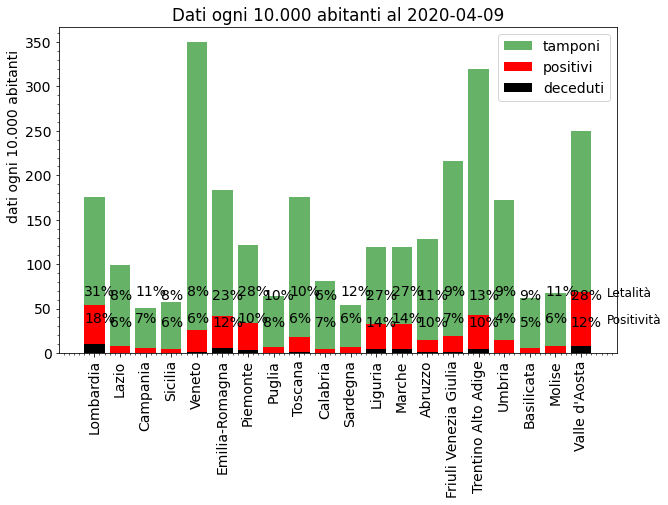

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(regioni, perc_tamponi, label='tamponi', alpha=0.6, color='green')
ax.bar(regioni, perc_positivi, label='positivi', color='red')
ax.bar(regioni, perc_deceduti, label='deceduti', color='black')

for i in range(regioni.size):
  if i % 2 == 0:
    offset = 4
  else:
    offset = 0
  plt.annotate('{:.0f}%'.format(100*perc_positivi[i]/perc_tamponi[i]), (i-0.4,60+offset))
  plt.annotate('{:.0f}%'.format(100*perc_deceduti[i]/perc_positivi[i]), (i-0.4,30+offset))
#ax.set_yscale('log')
ax.text(20, 63, 'Letalità', fontsize=12)
ax.text(20, 33, 'Positività', fontsize=12)
ax.set_title('Dati ogni 10.000 abitanti al '+str(dr.iloc[-1,0])[0:10])
ax.set_ylabel('dati ogni 10.000 abitanti', horizontalalignment = 'left', y=0.4)
plt.xticks(rotation=90)
plt.minorticks_on()
plt.legend()
plt.show()

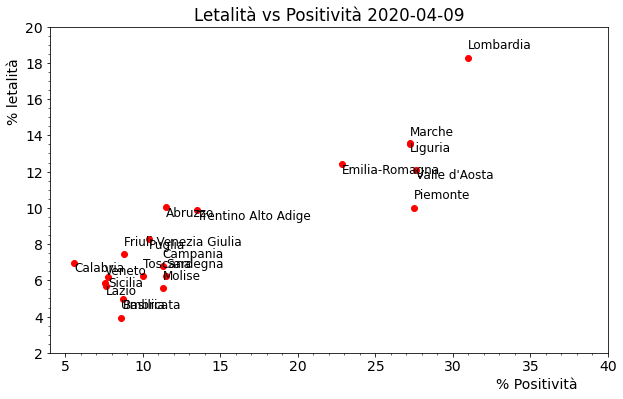

In [71]:
#col    = ('blue', 'red', 'black', 'green', 'cyan', 'magenta', 'yellow', 'darkblue', 'darkred', 'darkgrey', 'coral', 'khaki', 'teal',
#          'seagreen', 'navy', 'olive', 'tan', 'dimgrey', 'blueviolet', 'darkorange')
fig, ax = plt.subplots(figsize=(10,6))
x = 100*np.array(perc_positivi)/np.array(perc_tamponi)
y = 100*np.array(perc_deceduti)/np.array(perc_positivi)
#col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-', 'b1-', 'r2-', 'c3-', 'm4-', 'yh-', 'kH-', 'gd-', 'b>-', 'r<-', 'cp-', 'md-', 'yD-', 'k|-', 'g,-')
ax.plot(x, y, 'ro')

for k in range(x.size):
    if k % 2 == 0:
      offset = 0.5
    else:
      offset = -0.5
    plt.annotate(regioni[k], (x[k],y[k]+offset),fontsize=12)
plt.minorticks_on()
ax.set_xlim(4,40)
ax.set_ylim(2,20)
ax.set_title('Letalità vs Positività '+str(np.array(df['data'])[-1])[0:10])
ax.set_xlabel('% Positività', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)
plt.show()

In [72]:
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data")
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data")
dati_regioni = []
m = 3
for d in range(1,len(Lombardia)):
  day = d
  if d > 31:
    m = 4
    d = d-31
  data_sel = '2020-{0:02d}-{1:02d}T17:00:00'.format(m,d)
  print(data_sel)
  try:

    regioni = np.array(dpr['Regione'])
    perc_tamponi = []
    perc_positivi = []
    perc_deceduti = []
    for r in range(0, len(regioni)):
      if regioni[r]=='Trentino Alto Adige':
        popolazione = float(dpr.loc[dpr['Regione']=='Trentino Alto Adige']['Popolazione'].values[0])*1e3
        tamponi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        tamponi = tamponi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        perc_tamponi.append(tamponi/popolazione)
        positivi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        positivi = positivi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        perc_positivi.append(positivi/popolazione)
        deceduti = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        deceduti = deceduti + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        perc_deceduti.append(deceduti/popolazione)

      else:
        popolazione = float(dpr.loc[dpr['Regione']==regioni[r]]['Popolazione'].values[0])*1e3
        tamponi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        perc_tamponi.append(tamponi/popolazione)
        positivi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        perc_positivi.append(positivi/popolazione)
        deceduti = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        perc_deceduti.append(deceduti/popolazione)
    dati_regioni.append([day, data_sel, np.array(perc_tamponi), np.array(perc_positivi), np.array(perc_deceduti)])
  except:
    print ('No Data') 
  

2020-03-01T17:00:00
2020-03-02T17:00:00
No Data
2020-03-03T17:00:00
No Data
2020-03-04T17:00:00
2020-03-05T17:00:00
2020-03-06T17:00:00
2020-03-07T17:00:00
No Data
2020-03-08T17:00:00
No Data
2020-03-09T17:00:00
No Data
2020-03-10T17:00:00
No Data
2020-03-11T17:00:00
2020-03-12T17:00:00
2020-03-13T17:00:00
2020-03-14T17:00:00
2020-03-15T17:00:00
2020-03-16T17:00:00
2020-03-17T17:00:00
2020-03-18T17:00:00
2020-03-19T17:00:00
2020-03-20T17:00:00
2020-03-21T17:00:00
2020-03-22T17:00:00
2020-03-23T17:00:00
2020-03-24T17:00:00
2020-03-25T17:00:00
2020-03-26T17:00:00
2020-03-27T17:00:00
2020-03-28T17:00:00
2020-03-29T17:00:00
2020-03-30T17:00:00
2020-03-31T17:00:00
2020-04-01T17:00:00
2020-04-02T17:00:00
2020-04-03T17:00:00
2020-04-04T17:00:00
2020-04-05T17:00:00
2020-04-06T17:00:00
2020-04-07T17:00:00
2020-04-08T17:00:00
2020-04-09T17:00:00
2020-04-10T17:00:00
No Data
2020-04-11T17:00:00
No Data
2020-04-12T17:00:00
No Data
2020-04-13T17:00:00
No Data
2020-04-14T17:00:00
No Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0
waring divisione per 0


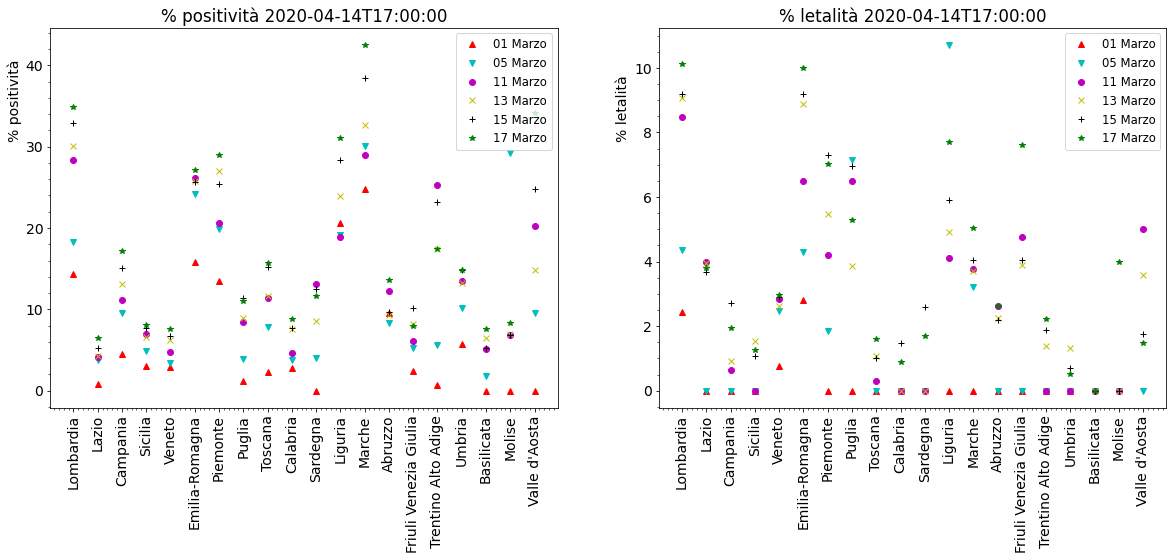

In [73]:
dati_regioni = np.array(dati_regioni)
col    = ('b.', 'r^', 'cv', 'mo', 'yx', 'k+', 'g*')
fig, ax = plt.subplots(1, 2, figsize=(20,7))
coli = 0
for d in range(0, len(dati_regioni), 2 ):
  coli +=1
  try:
    ax[0].plot(regioni, 100*dati_regioni[d][3]/dati_regioni[d][2], col[coli], label='{:02d} Marzo'.format(dati_regioni[d][0]))
  except:
    print ('waring divisione per 0')
  try:
    ax[1].plot(regioni, 100*dati_regioni[d][4]/dati_regioni[d][3], col[coli], label='{:02d} Marzo'.format(dati_regioni[d][0]))
  except:
    print ('waring divisione per 0')
ax[0].set_title('% positività '+data_sel)
ax[0].set_ylabel('% positività', horizontalalignment = 'left', y=0.7)
ax[1].set_title('% letalità '+data_sel)
ax[1].set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)

ax[0].set_xticklabels(regioni, rotation=90)
ax[0].minorticks_on()
ax[0].legend(loc=1, prop={'size':'small'})
ax[1].set_xticklabels(regioni, rotation=90)
ax[1].minorticks_on()
ax[1].legend(loc=1, prop={'size':'small'})
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


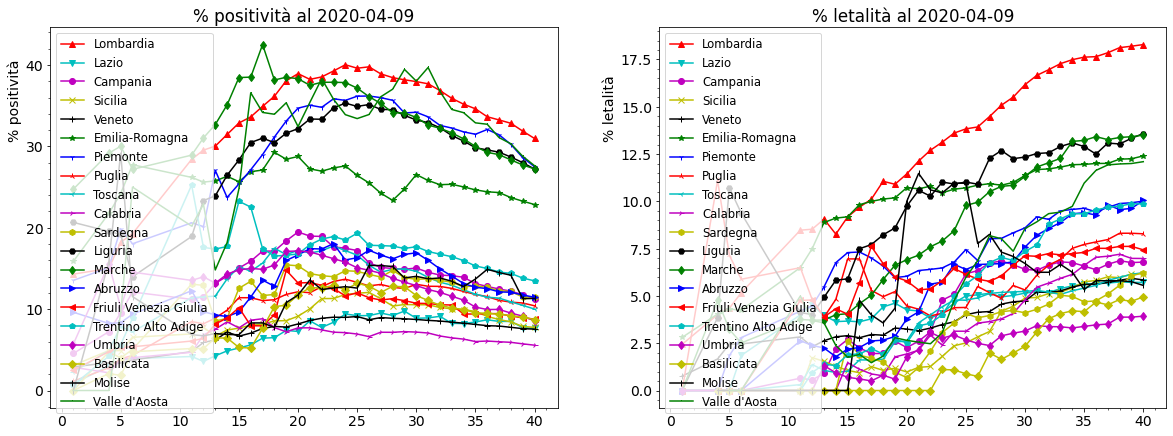

In [74]:
from matplotlib.ticker import MaxNLocator
col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-', 'b1-', 'r2-', 'c3-', 'm4-', 'yh-', 'kH-', 'gd-', 'b>-', 'r<-', 'cp-', 'md-', 'yD-', 'k|-', 'g,-')
fig, ax = plt.subplots(1, 2, figsize=(20,7))

coli = 0
for r in range(0, len(regioni)):
  positivity = []
  letality = []
  coli +=1
  if coli >= len(col):
    coli = 0
  for d in range(0,len(dati_regioni)):
    positivity.append([100*dati_regioni[d][3][r]/dati_regioni[d][2][r]])
    letality.append(  [100*dati_regioni[d][4][r]/dati_regioni[d][3][r]])
    

  ax[0].plot(dati_regioni[:,0], positivity, col[coli], label='{:s}'.format(regioni[r]))
  ax[1].plot(dati_regioni[:,0], letality, col[coli], label='{:s}'.format(regioni[r]))
ax[0].set_title('% positività al '+str(dr.iloc[-1,0])[0:10])
ax[0].set_ylabel('% positività', horizontalalignment = 'left', y=0.7)
ax[1].set_title('% letalità al '+str(dr.iloc[-1,0])[0:10])
ax[1].set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].minorticks_on()
ax[0].legend(loc=2, prop={'size':'small'})
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].minorticks_on()
ax[1].legend(loc=2, prop={'size':'small'})
plt.show()

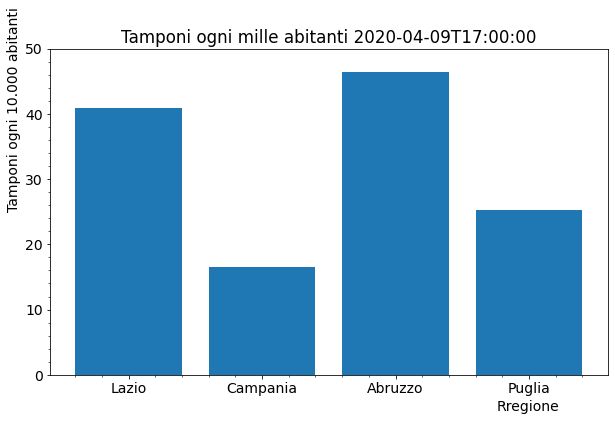

In [75]:
P_Lazio = 5.897e6
P_Campania = 5.827e6
P_Abruzzo = 1.315e6
P_Puglia = 4.048e6
y = [(10000*dr.loc[(dr['denominazione_regione'] == 'Lazio') & (dr['data'] == '2020-03-27T17:00:00')]['tamponi'].values/P_Lazio)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Campania') & (dr['data'] == '2020-03-27T17:00:00')]['tamponi'].values/P_Campania)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Abruzzo') & (dr['data'] == '2020-03-27T17:00:00')]['tamponi'].values/P_Abruzzo)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Puglia') & (dr['data'] == '2020-03-27T17:00:00')]['tamponi'].values/P_Puglia)[0]
     ]
fig, ax = plt.subplots(figsize=(10,6))
xl = ['Lazio', 'Campania', 'Abruzzo', 'Puglia']
x = [0,1,2,3]
#ax.plot(xl, y, linestyle='dashed')
ax.bar(xl, y)
#ax.set_xticks(x, xl)
ax.set_ylim(0, 50)
ax.set_title('Tamponi ogni mille abitanti '+str(np.array(df['data'])[-1]))
ax.set_xlabel('Rregione', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('Tamponi ogni 10.000 abitanti', horizontalalignment = 'left', y=0.5)
plt.minorticks_on()
plt.show()

In [76]:
# DATI Provincie
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
dp = pd.read_csv(url_csv_file)
dp.head()



,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN,NaN
1,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN,NaN
3,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN,NaN
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,0,NaN,NaN


In [0]:
Roma = dp.loc[(dp['denominazione_provincia'] == 'Roma')].sort_values(by="data")
Milano = dp.loc[(dp['denominazione_provincia'] == 'Milano')].sort_values(by="data")
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data")
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data")


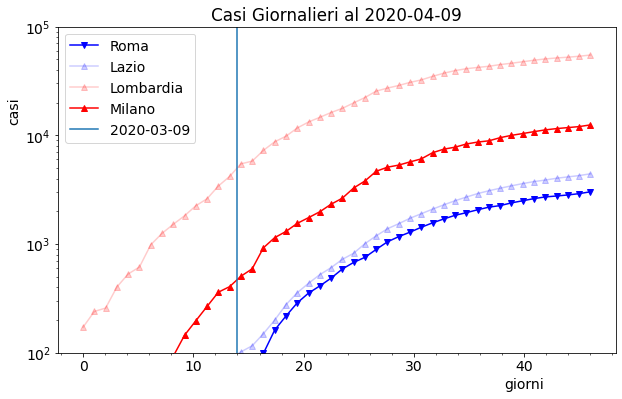

In [78]:
T_days =  len(Roma)
x = np.linspace(0, T_days, T_days)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, Roma['totale_casi'], 'bv-', label='Roma')
ax.plot(x, Lazio['totale_casi'], 'b^-', label='Lazio', alpha=0.2)
ax.plot(x, Lombardia['totale_casi'], 'r^-', label='Lombardia', alpha=0.2)
ax.plot(x, Milano['totale_casi'], 'r^-', label='Milano')

#ymax = 100000
#yptxt = ymax - ymax*0.05
#ax.set_ylim(5000,ymax)
ax.set_ylim(100,100000)
#ax.set_xlim(20,60)
ax.set_title('Casi Giornalieri al '+str(Roma.iloc[-1, 0][0:10]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
day=14
ax.axvline(day, label='{:s}'.format(Roma.iloc[day, 0][0:10]))

ax.set_yscale('log')
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'medium'})
plt.show()